In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
#Download datasets
!kaggle datasets download -d andrewmvd/face-mask-detection

 95% 377M/398M [00:02<00:00, 182MB/s]
100% 398M/398M [00:02<00:00, 160MB/s]


In [3]:
import zipfile
import os, random
from PIL import Image
import glob
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

import tensorflow as tf
import keras as kr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import RMSprop

import keras.layers as l
import keras.models as m
import keras.optimizers as o

In [4]:
#Unzip files
zip_ref=zipfile.ZipFile("/content/face-mask-detection.zip", 'r')
zip_ref.extractall("/content/face_mask_detection")
zip_ref.close()

In [5]:
#Extract important information from annotation files
annotations_directory = '/content/face_mask_detection/annotations/'
images_directory = '/content/face_mask_detection/images/'

information = {
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
            "name":[],    
            "file":[],
            "width":[],
            "height":[],
           }

#Extract necessary information from annotation files
for anno in glob.glob(annotations_directory+"/*.xml"):
    tree = ET.parse(anno)
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))

        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text
                    information['name']+=[name]
                    information['width']+=[width]
                    information['height']+=[height] 
                    information['file']+=[anno.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            information['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            information['ymin']+=[ymin]
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            information['xmax']+=[xmax]
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            information['ymax']+=[ymax]

#Create pandas dataframe
df_annotations=pd.DataFrame(information)

#Create a class column
df_annotations['class']=df_annotations['name'].map({'with_mask':0, 'mask_weared_incorrect':1, 'without_mask':2})

#Print how many pictures from each class
print(f"With Mask:", df_annotations.value_counts("class")[0])
print(f"Wrong Mask:", df_annotations.value_counts("class")[1])
print(f"Without Mask:", df_annotations.value_counts("class")[2])

#Create training and validation  directories
!mkdir "/content/training"
!mkdir "/content/training/with_mask"
!mkdir "/content/training/without_mask"

!mkdir "/content/validation"
!mkdir "/content/validation/with_mask"
!mkdir "/content/validation/without_mask"

#Crop images and split them to with_mask (class 1) and without_mask directories (class 1 and 2)
for index, row in df_annotations.iterrows():

    file_name = row["file"]
    file_path = images_directory + file_name + ".png"

    # Opens a image in RGB mode
    im = Image.open(file_path)

    # Size of the image in pixels (size of original image)
    width, height = im.size

    # Setting the points for cropped image
    left=row["xmin"]
    top=row["ymin"]
    right=row["xmax"]
    bottom=row["ymax"]

    # Cropped image of above dimension
    # (It will not change original image)
    im1 = im.crop((left, top, right, bottom))
    if row["class"] == 0:
        im1.save("/content/training/with_mask/" + "with_mask" + str(index) + ".png")
    else:
        im1.save("/content/training/without_mask/" + "without_mask" + str(index) + ".png")

#Calculate how many images to extract for the validations set for each class (10%)
num_validation_with = math.floor(len(os.listdir("/content/training/with_mask"))*0.1)
num_validation_without = math.floor(len(os.listdir("/content/training/without_mask"))*0.1)

print("Total number of images with mask:", math.floor(len(os.listdir("/content/training/with_mask"))))
print("Total number of images without mask:", math.floor(len(os.listdir("/content/training/without_mask"))))

#Choose randomly 10% of the images and move them to the validation set
for png in range(num_validation_with):
    filename = random.choice(os.listdir("/content/training/with_mask"))
    os.rename("/content/training/with_mask/" + filename, "/content/validation/with_mask/" + filename)

for png in range(num_validation_without):
    filename = random.choice(os.listdir("/content/training/without_mask"))
    os.rename("/content/training/without_mask/" + filename, "/content/validation/without_mask/" + filename)

With Mask: 3232
Wrong Mask: 123
Without Mask: 717
Total number of images with mask: 3232
Total number of images without mask: 840


In [6]:
#rm -r training validation face_mask_detection

In [7]:
print("Training set:")
print("\t-With mask:", math.floor(len(os.listdir("/content/training/with_mask"))))
print("\t-Without mask:", math.floor(len(os.listdir("/content/training/without_mask"))))

print("Validation set:")
print("\t-With mask:", math.floor(len(os.listdir("/content/validation/with_mask"))))
print("\t-Without mask:", math.floor(len(os.listdir("/content/validation/without_mask"))))

Training set:
	-With mask: 2909
	-Without mask: 756
Validation set:
	-With mask: 323
	-Without mask: 84


In [8]:
train_num = math.floor(len(os.listdir("/content/training/with_mask"))) + math.floor(len(os.listdir("/content/training/without_mask")))
validation_num = math.floor(len(os.listdir("/content/validation/with_mask"))) + math.floor(len(os.listdir("/content/validation/without_mask")))

In [35]:
#Data Augmentation
train_datagen = ImageDataGenerator(
  rotation_range=5,
  horizontal_flip=True,
  width_shift_range=0.1,
  height_shift_range=0.1,
  rescale = 1. / 255,
  zoom_range=0.05,
)
validation_datagen = ImageDataGenerator(rescale=1./255)

#Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    "/content/training",      #This is the source directory for training images
    target_size = (32, 32),   #All images will be resized to 32x32
    batch_size = 64,
    class_mode = "binary"     #Since we use binary_crossentropy loss, we need binary labels
)

#Flow validation images in batches of 64 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    "/content/validation",    #This is the source directory for training images
    target_size = (32, 32),   #All images will be resized to 32x32
    batch_size = 64,
    class_mode = "binary"     #Since we use binary_crossentropy loss, we need binary labels
)

Found 3665 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


In [43]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get("val_accuracy") >0.97) and (logs.get("val_loss") <0.1) and (logs.get("val_accuracy") >0.96):
            print("\nReached >97% validation accuracy and <0.1 validation loss so canceling training!")
            self.model.stop_training=True

callbacks=myCallback()

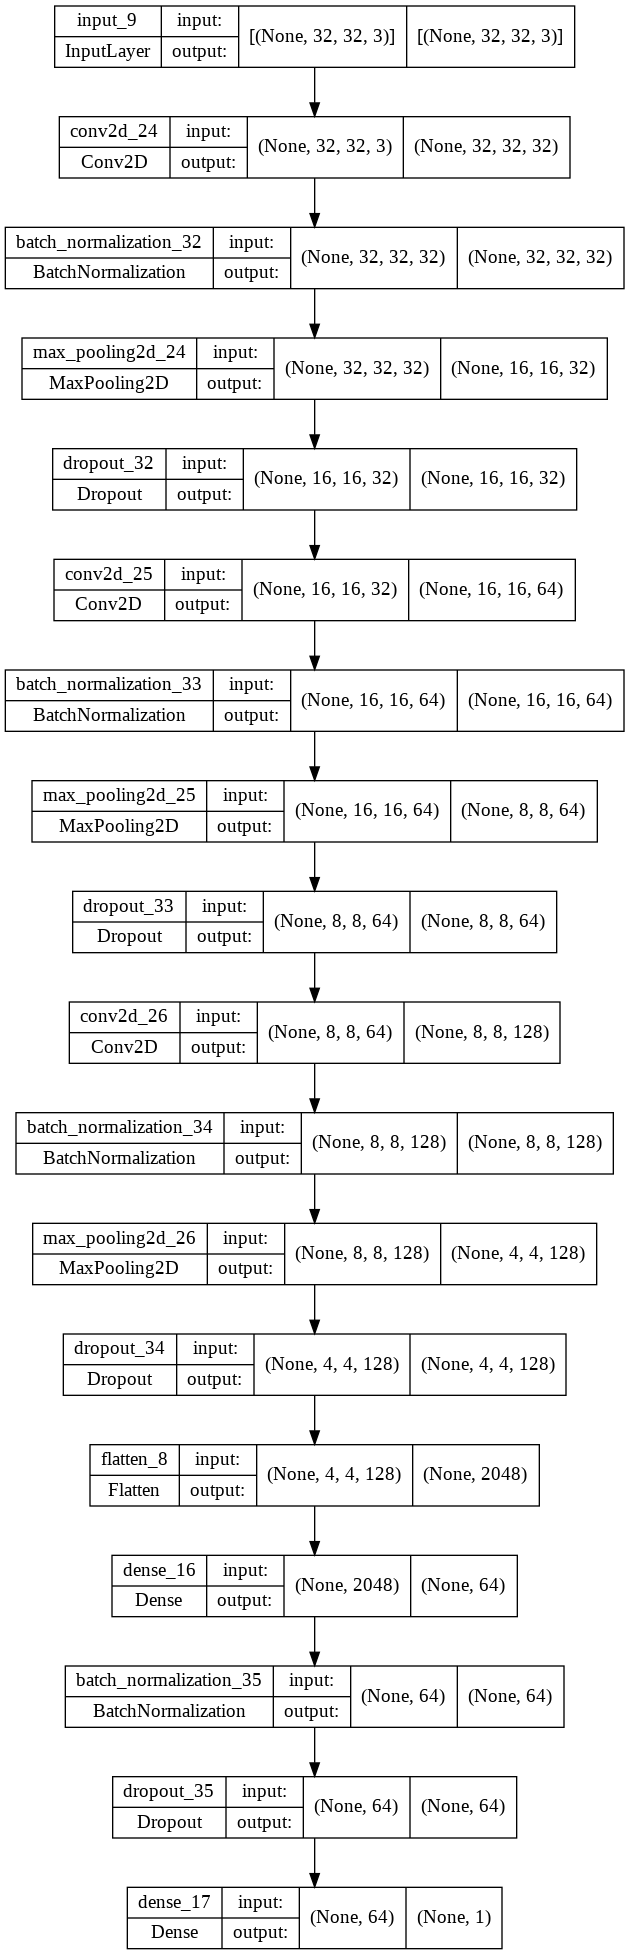

In [44]:
Input = l.Input(shape=(32, 32, 3))

#First Convolutional layer
hidden = l.Conv2D(32, (3,3), padding='same', activation=tf.keras.layers.LeakyReLU())(Input)
hidden = l.BatchNormalization()(hidden) # Reduces ovefitting
hidden = l.MaxPooling2D((2,2))(hidden)
hidden = l.Dropout(0.1)(hidden)

#Second Convolutional layer
hidden = l.Conv2D(64, (3,3), padding='same', activation=tf.keras.layers.LeakyReLU())(hidden)
hidden = l.BatchNormalization()(hidden)
hidden = l.MaxPooling2D((2,2))(hidden)
hidden = l.Dropout(0.2)(hidden)

#Third Convolutional layer
hidden = l.Conv2D(128, (3,3), padding='same', activation=tf.keras.layers.LeakyReLU())(hidden)
hidden = l.BatchNormalization()(hidden)
hidden = l.MaxPooling2D((2,2))(hidden)
hidden = l.Dropout(0.3)(hidden)

hidden = l.Flatten()(hidden)
hidden = l.Dense(64, activation=tf.keras.layers.LeakyReLU())(hidden)
hidden = l.BatchNormalization()(hidden)
hidden = l.Dropout(0.4)(hidden)


output = l.Dense(1, activation='sigmoid')(hidden)

mask_detection = m.Model(Input, output)

#mask_detection.summary()
mask_detection.compile(
    loss='binary_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.0005),
    metrics=["accuracy"]
)

dot_img_file = 'mask_detection.png'
tf.keras.utils.plot_model(mask_detection, to_file=dot_img_file, show_shapes=True)

In [45]:
history = mask_detection.fit(train_generator,
    steps_per_epoch = math.floor(train_num / 64),
    validation_data = validation_generator,
    validation_steps = math.floor(validation_num / 64),
    epochs = 100,
    callbacks = [callbacks]
)

Epoch 1/100
57/57 [==============================] - 5s 72ms/step - loss: 0.5644 - accuracy: 0.7701 - val_loss: 0.9855 - val_accuracy: 0.2031
Epoch 2/100
57/57 [==============================] - 4s 65ms/step - loss: 0.3852 - accuracy: 0.8753 - val_loss: 1.2801 - val_accuracy: 0.2057
Epoch 3/100
57/57 [==============================] - 4s 66ms/step - loss: 0.3404 - accuracy: 0.8956 - val_loss: 1.2099 - val_accuracy: 0.2083
Epoch 4/100
57/57 [==============================] - 4s 66ms/step - loss: 0.2879 - accuracy: 0.9200 - val_loss: 0.7336 - val_accuracy: 0.5911
Epoch 5/100
57/57 [==============================] - 4s 64ms/step - loss: 0.2547 - accuracy: 0.9253 - val_loss: 0.6088 - val_accuracy: 0.7422
Epoch 6/100
57/57 [==============================] - 4s 64ms/step - loss: 0.2395 - accuracy: 0.9300 - val_loss: 0.2647 - val_accuracy: 0.9375
Epoch 7/100
57/57 [==============================] - 4s 64ms/step - loss: 0.2089 - accuracy: 0.9397 - val_loss: 0.4692 - val_accuracy: 0.8464
Epoch 

In [46]:
mask_detection.save('mask_detection_model.h5')